# Compare BRD4 Inhibitors Point Clouds

### Libraries

In [1]:
import sys

sys.path.append("..")

In [2]:
import open3d as o3d
import numpy as np
import seaborn as sns
import pandas as pd

import re, os
from io import StringIO

import py3Dmol

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import PandasTools

import ipywidgets as widgets
from IPython.display import HTML

from itertools import combinations_with_replacement
from open3d.web_visualizer import draw

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


INFO - 2021-08-17 11:10:44,965 - __init__ - Enabling RDKit 2021.03.3 jupyter extensions


[Open3D INFO] Resetting default logger to print to terminal.


In [3]:
from score_pcd import fit_and_score

## BRD4 Inhibitors

Load BRD4 inhibitors (point clouds and molecules):

In [4]:
path = "ligands/BRD4"
files = [os.path.join(path, f) for f in os.listdir(path) if os.path.splitext(f)[-1] == ".pcd" and os.path.splitext(f)[0][-4:] == "tran"]

# Sort BRD4 ligand files by number
r = re.compile("\d{1,2}")
files.sort(key=lambda f: int(r.search(os.path.basename(f)).group()))

print(files)

pcds = []
mols = []
for f in files:
    pcd = o3d.io.read_point_cloud(f)
    pcds.append(pcd)

    s = Chem.SDMolSupplier(f.replace(".pcd", ".sdf"))
    mol = next(s)
    mols.append(mol)

['ligands/BRD4/ligand-1_tran.pcd', 'ligands/BRD4/ligand-2_tran.pcd', 'ligands/BRD4/ligand-3_tran.pcd', 'ligands/BRD4/ligand-4_tran.pcd', 'ligands/BRD4/ligand-5_tran.pcd', 'ligands/BRD4/ligand-6_tran.pcd', 'ligands/BRD4/ligand-7_tran.pcd', 'ligands/BRD4/ligand-8_tran.pcd', 'ligands/BRD4/ligand-9_tran.pcd', 'ligands/BRD4/ligand-10_tran.pcd']


Visualize 3D conformations of BRD4 inhibitors using `py3Dmol`:

In [5]:
def update(index=0):
    sio = StringIO()
    with Chem.SDWriter(sio) as w:
        w.write(mols[index])

    view = py3Dmol.view(data=sio.getvalue(), style={'stick':{'colorscheme':'greyCarbon'}})
    view.zoomTo()
    view.show()
    
_ = widgets.interact(update, index=widgets.IntSlider(min=0, max=len(mols)-1, step=1, value=0))

interactive(children=(IntSlider(value=0, description='index', max=9), Output()), _dom_classes=('widget-interac…

## BRD4 Inhibitors Fitting and Scoring

Fit ans score the BRD4 inhibitors pairwise:

In [6]:
# Score is not symmetric because RANSAC is currently not deterministic
# See https://github.com/intel-isl/Open3D/issues/1263
# Would the score be symmetric if this was not the case?
n = len(pcds)
Sfitness = np.zeros((n,n))

for i, pcd1 in enumerate(pcds):
    for j, pcd2 in enumerate(pcds):
        gfit, cfit, transform = fit_and_score((pcd1, pcd2), voxel_size=0.5, threshold=0.5)
        Sfitness[i, j] = cfit.fitness

The fitness matrix is not symmetric because [RANSAC is not deterministic](https://github.com/intel-isl/Open3D/issues/1263):

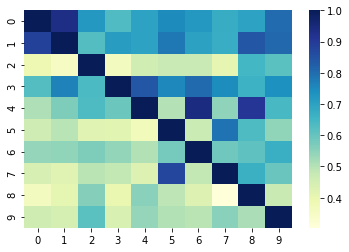

In [7]:
ax = sns.heatmap(Sfitness, cmap="YlGnBu")

We can see that inhibitors sharing similar scaffolds have a high fitness score when their corresponding point clouds are aligned.

In [8]:
def align_and_show(idx1, idx2):
    pcd1, pcd2 = pcds[idx1], pcds[idx2]
    mol1, mol2 = mols[idx1], mols[idx2]
    
    fit, cfit, tran = fit_and_score((pcd1, pcd2), voxel_size=0.5, threshold=0.5)

    # Get coordinates to transform
    coords = mol1.GetConformer(0).GetPositions()

    # Augment coordinates with ones
    coords_aug = np.ones((coords.shape[0], 4))
    coords_aug[:,:3] = coords

    # Compute new (transformed) coordinates
    coords_new = np.matmul(tran, coords_aug.T)[:3,:].T

    # Add new coordinates as conformer
    n_atoms = mol1.GetNumAtoms()
    conf = Chem.Conformer(n_atoms)
    for i in range(n_atoms):
        conf.SetAtomPosition(i, coords_new[i,:])

    _ = mol1.AddConformer(conf, assignId=True)

    # Create view
    p = py3Dmol.view()
    p.addModel(Chem.MolToMolBlock(mol1, confId=0),'sdf')
    p.addModel(Chem.MolToMolBlock(mol1, confId=1),'sdf')
    p.addModel(Chem.MolToMolBlock(mol2, confId=0),'sdf')

    p.setStyle({"model": 0}, {'stick':{'colorscheme':'lightgreyCarbon'}})
    p.setStyle({"model": 1}, {'stick':{'colorscheme':'redCarbon'}})
    p.setStyle({"model": 2}, {'stick':{'colorscheme':'greyCarbon'}})

    p.zoomTo()

    return p

In [9]:
align_and_show(0, 1)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [10]:
align_and_show(4, 6)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [11]:
align_and_show(5, 7)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [12]:
align_and_show(8, 9)

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

,,,,,,,,,,
,1.000000,0.932406,0.721670,0.632207,0.699801,0.747515,0.721670,0.675944,0.699801,0.803181
,0.883764,1.000000,0.627306,0.712177,0.699262,0.780443,0.702952,0.671587,0.841328,0.808118
,0.386139,0.355336,1.000000,0.363036,0.456546,0.474147,0.473047,0.407041,0.649065,0.616062
,0.625523,0.765690,0.638075,1.000000,0.841004,0.753138,0.805439,0.744770,0.661088,0.736402
,0.510116,0.565029,0.632948,0.592486,1.000000,0.501445,0.942197,0.547688,0.908960,0.643064
,0.463415,0.496288,0.419936,0.417815,0.369035,1.000000,0.468717,0.787911,0.634146,0.545069
,0.539683,0.544974,0.566138,0.542328,0.503968,0.579365,1.000000,0.587302,0.608466,0.670635
,0.441347,0.419280,0.493612,0.480836,0.430894,0.872242,0.481998,1.000000,0.667828,0.595819
,0.362129,0.410995,0.556719,0.401396,0.553229,0.489529,0.430192,0.303665,1.000000,0.471204
,0.459980,0.446809,0.613982,0.438703,0.540020,0.504559,0.492401,0.553191,0.510638,1.000000

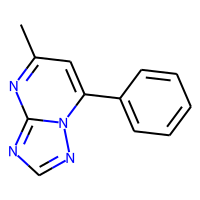
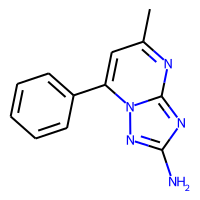
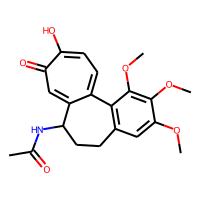
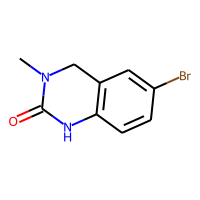
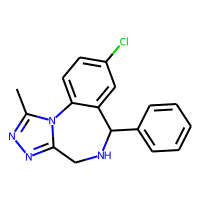
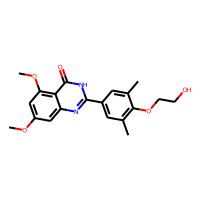
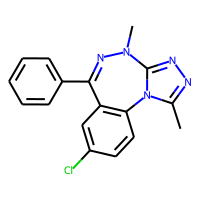
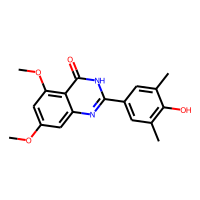
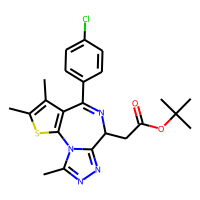
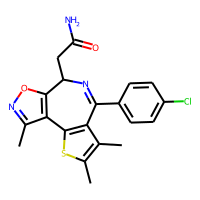
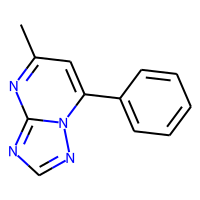
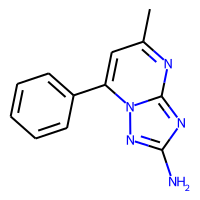
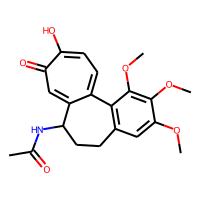
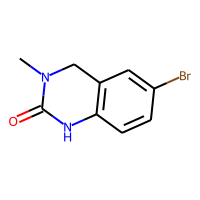
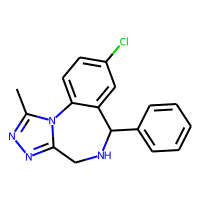
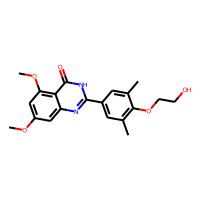
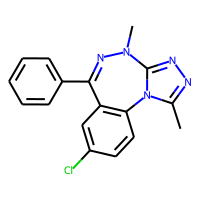
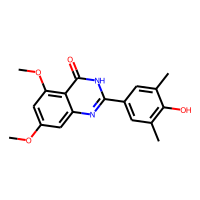
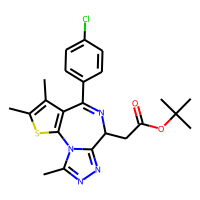
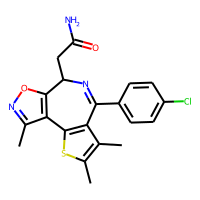

In [13]:
# Molecuiles in 2D for visualization
from copy import deepcopy

mols2d = [deepcopy(mol) for mol in mols]

for mol in mols2d:
    AllChem.Compute2DCoords(mol)

df =pd.DataFrame(Sfitness, columns=mols2d, index=mols2d)
PandasTools.ChangeMoleculeRendering(df, renderer="SVG")
df.style.background_gradient(cmap=sns.cm.rocket_r)

In [14]:
pcds[0]

PointCloud with 503 points.

In [15]:
from open3d.web_visualizer import draw

draw(pcds[0])

WebVisualizer(window_uid='window_0')